In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import zipfile
import gdown
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
!unzip gdrive/MyDrive/Ishan\ Thathsara/TrainingData2.zip

Archive:  gdrive/MyDrive/Ishan Thathsara/TrainingData2.zip
   creating: TrainingData2/
   creating: TrainingData2/dark/
  inflating: TrainingData2/dark/augmented_95226316.jpg  
  inflating: TrainingData2/dark/96488311.jpg  
  inflating: TrainingData2/dark/103674846.jpg  
  inflating: TrainingData2/dark/104412423.jpg  
  inflating: TrainingData2/dark/104880284.jpg  
  inflating: TrainingData2/dark/105943829.jpg  
  inflating: TrainingData2/dark/107217322.jpg  
  inflating: TrainingData2/dark/augmented_39251957.jpg  
  inflating: TrainingData2/dark/augmented_39252018.jpg  
  inflating: TrainingData2/dark/augmented_42932747.jpg  
  inflating: TrainingData2/dark/augmented_43615605.jpg  
  inflating: TrainingData2/dark/augmented_44981770.jpg  
  inflating: TrainingData2/dark/augmented_44990958.jpg  
  inflating: TrainingData2/dark/augmented_44991031.jpg  
  inflating: TrainingData2/dark/augmented_45869598.jpg  
  inflating: TrainingData2/dark/augmented_47287501.jpg  
  inflating: TrainingDa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
# Define the dataset directory
dataset_dir = '/content/TrainingData2'

# Update categories based on actual directory names
categories = ['dark', 'light', 'mid-dark', 'mid-light']

# Create directories for train and validation split
train_dir = '/content/TrainingData2/working/train'
valid_dir = '/content/TrainingData2working/val'

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, category), exist_ok=True)

# Load image paths and labels
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(dataset_dir, category)
    for img_name in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, img_name))
        labels.append(category)

# Split data into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Move the images to train and validation directories
for img, label in zip(train_paths, train_labels):
    shutil.copy(img, os.path.join(train_dir, label, os.path.basename(img)))

for img, label in zip(val_paths, val_labels):
    shutil.copy(img, os.path.join(valid_dir, label, os.path.basename(img)))

print("Data has been successfully split and organized.")

Data has been successfully split and organized.


In [21]:
# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 800 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [24]:
import tensorflow as tf

# Custom F1-score metric for Keras
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [25]:
# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)  # 4 classes (dark, light, mid-dark, mid-light)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')])

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
# Check class indices to ensure 4 classes
print("Class indices:", train_generator.class_indices)
print("Number of classes:", train_generator.num_classes)

Class indices: {'dark': 0, 'light': 1, 'mid-dark': 2, 'mid-light': 3}
Number of classes: 4


In [27]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 776ms/step - accuracy: 0.3845 - auc: 0.6489 - f1_score: 0.3685 - loss: 1.9426 - precision: 0.4106 - recall: 0.3344 - val_accuracy: 0.6000 - val_auc: 0.8691 - val_f1_score: 0.5575 - val_loss: 0.8247 - val_precision: 0.6554 - val_recall: 0.4850
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 0.6175 - auc: 0.8733 - f1_score: 0.5805 - loss: 0.8290 - precision: 0.6748 - recall: 0.5097 - val_accuracy: 0.6150 - val_auc: 0.8797 - val_f1_score: 0.6179 - val_loss: 0.7773 - val_precision: 0.6746 - val_recall: 0.5700
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - accuracy: 0.7142 - auc: 0.9086 - f1_score: 0.6742 - loss: 0.7127 - precision: 0.7436 - recall: 0.6169 - val_accuracy: 0.6250 - val_auc: 0.8735 - val_f1_score: 0.5879 - val_loss: 0.8176 - val_precision: 0.6524 - val_recall: 0.5350
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 462ms/step - accuracy: 0.6968 - auc: 0.9121 - f1_score: 0.6724 - loss: 0.6899 - precision: 0.7367 - rec

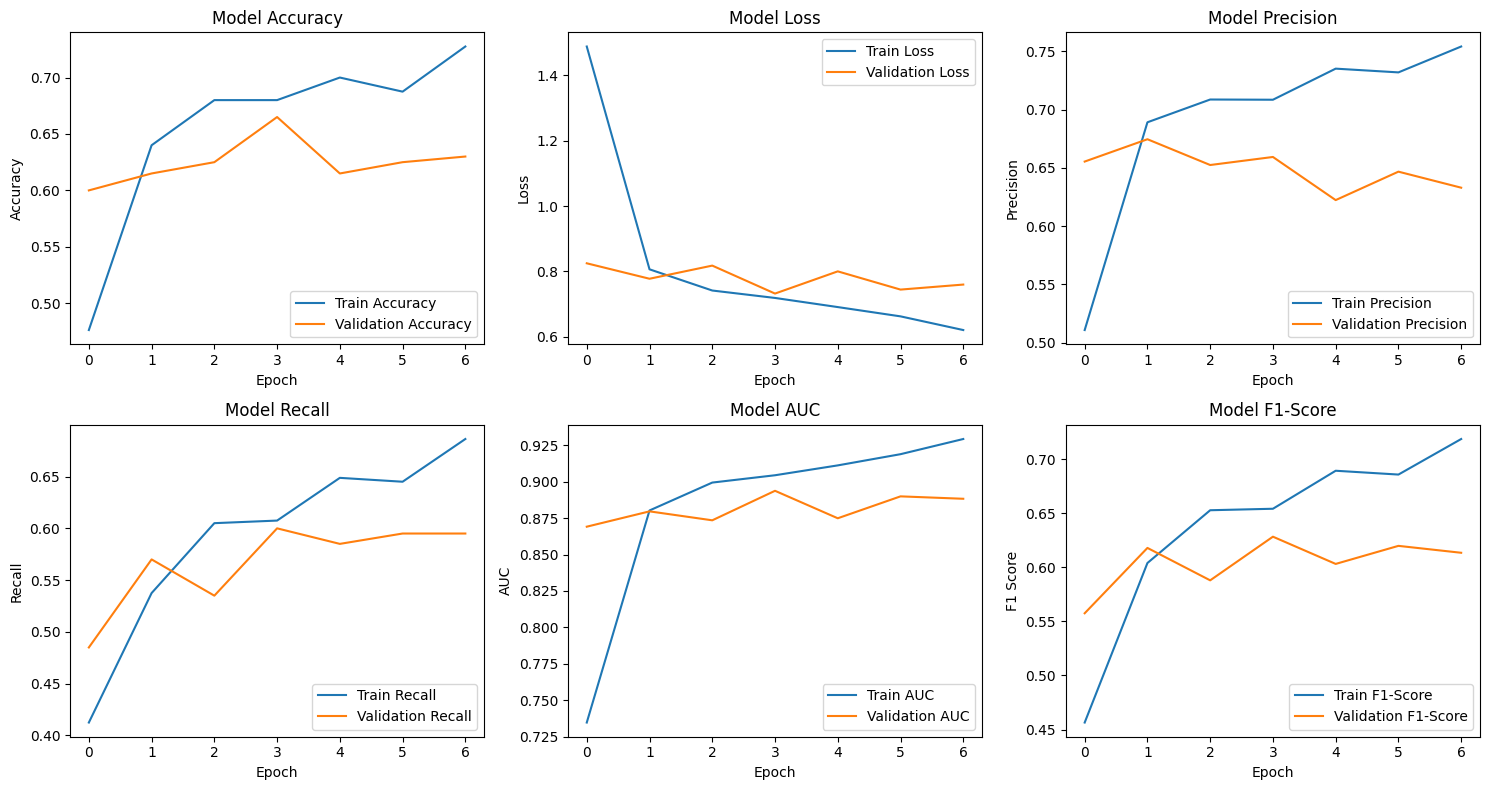

In [28]:
# Plot training & validation accuracy, loss, precision, recall, AUC, and F1-score
plt.figure(figsize=(15, 8))

# Accuracy plot
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Precision plot
plt.subplot(2, 3, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='lower right')

# Recall plot
plt.subplot(2, 3, 4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='lower right')

# AUC plot
plt.subplot(2, 3, 5)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')

# F1 Score plot
plt.subplot(2, 3, 6)
plt.plot(history.history['f1_score'], label='Train F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [29]:
# Evaluate the model on validation data
validation_results = model.evaluate(validation_generator)

# Extract metrics
validation_loss = validation_results[0]
validation_accuracy = validation_results[1]
validation_precision = validation_results[2]
validation_recall = validation_results[3]
validation_auc = validation_results[4]
validation_f1_score = validation_results[5]

# Print validation metrics
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")
print(f"Validation Precision: {validation_precision:.4f}")
print(f"Validation Recall: {validation_recall:.4f}")
print(f"Validation AUC: {validation_auc:.4f}")
print(f"Validation F1-Score: {validation_f1_score:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6461 - auc: 0.8853 - f1_score: 0.6102 - loss: 0.7476 - precision: 0.6366 - recall: 0.5861
Validation Loss: 0.7319
Validation Accuracy: 66.50%
Validation Precision: 0.6593
Validation Recall: 0.6000
Validation AUC: 0.8938
Validation F1-Score: 0.6283


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 752ms/step
Unique predicted classes: [0 1 2 3]
Unique true classes: [0 1 2 3]


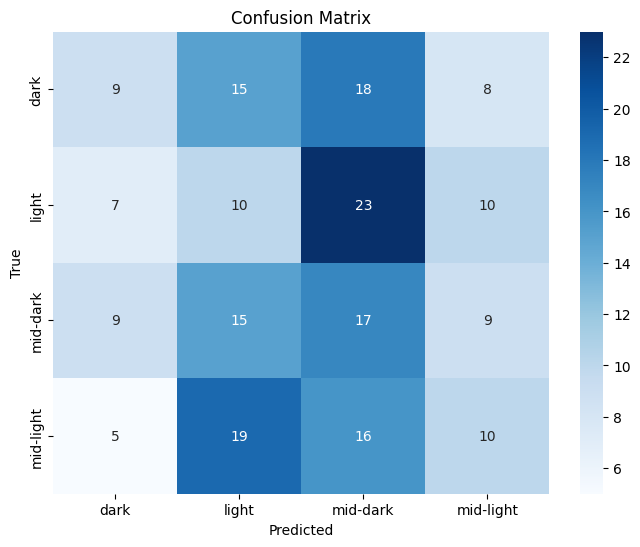

              precision    recall  f1-score   support

        dark       0.30      0.18      0.23        50
       light       0.17      0.20      0.18        50
    mid-dark       0.23      0.34      0.27        50
   mid-light       0.27      0.20      0.23        50

    accuracy                           0.23       200
   macro avg       0.24      0.23      0.23       200
weighted avg       0.24      0.23      0.23       200



In [30]:
# Predict the classes on validation data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true classes
y_true = validation_generator.classes

# Check unique predicted and true classes
unique_pred_classes = np.unique(y_pred)
unique_true_classes = np.unique(y_true)

print(f"Unique predicted classes: {unique_pred_classes}")
print(f"Unique true classes: {unique_true_classes}")

# Adjust target names to match actual predicted classes
# This ensures the classification report will reflect only the predicted classes
actual_categories = [categories[i] for i in unique_pred_classes]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actual_categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report with adjusted labels
print(classification_report(y_true, y_pred, labels=unique_pred_classes, target_names=actual_categories))

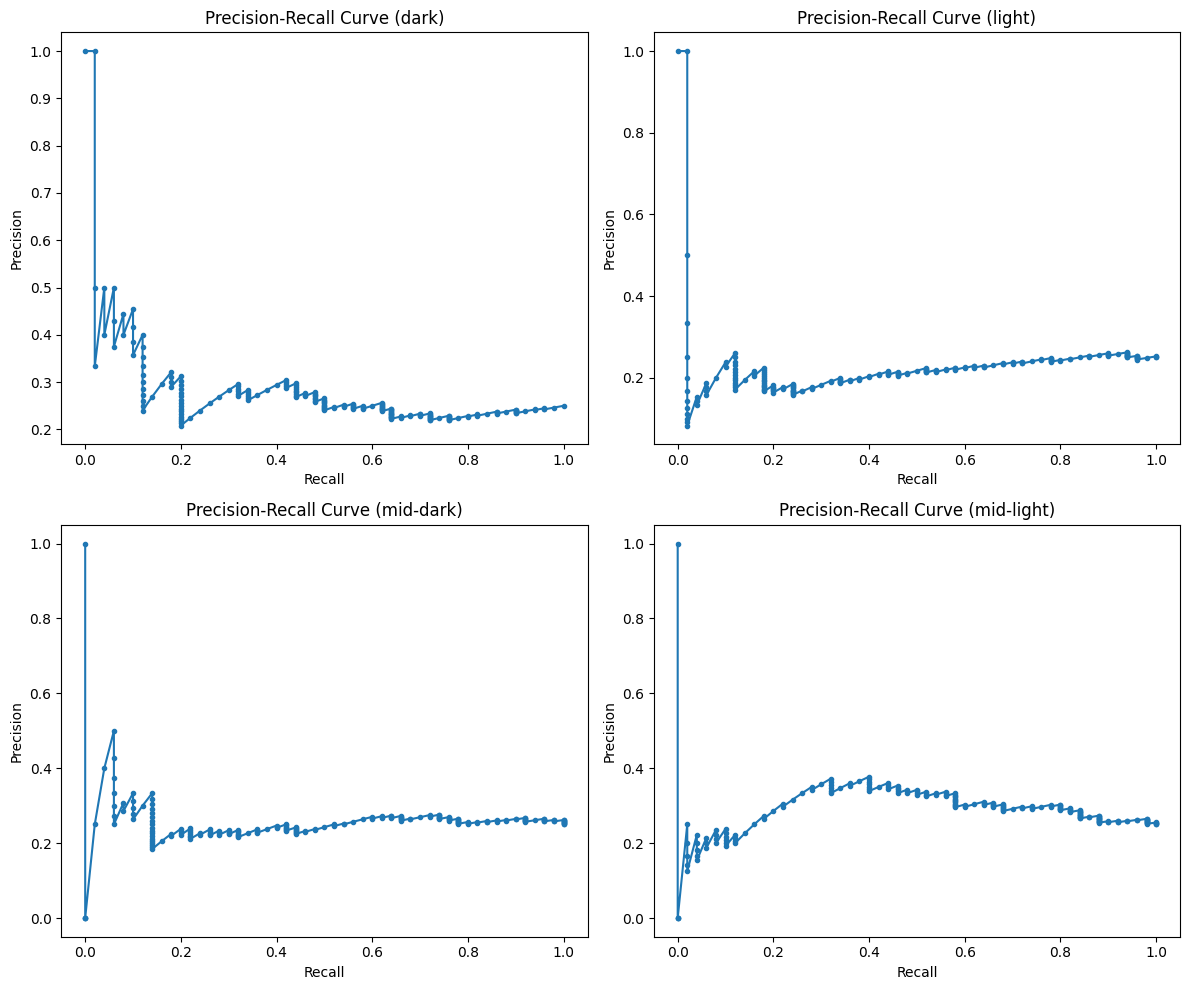

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Number of classes
num_classes = 4
class_labels = ['dark', 'light', 'mid-dark', 'mid-light']  # Adjust according to your labels

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten for easy indexing

# Loop through each class
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true == i, Y_pred[:, i])  # Compute PR curve

    axes[i].plot(recall, precision, marker='.')
    axes[i].set_title(f'Precision-Recall Curve ({class_labels[i]})')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')

plt.tight_layout()
plt.show()

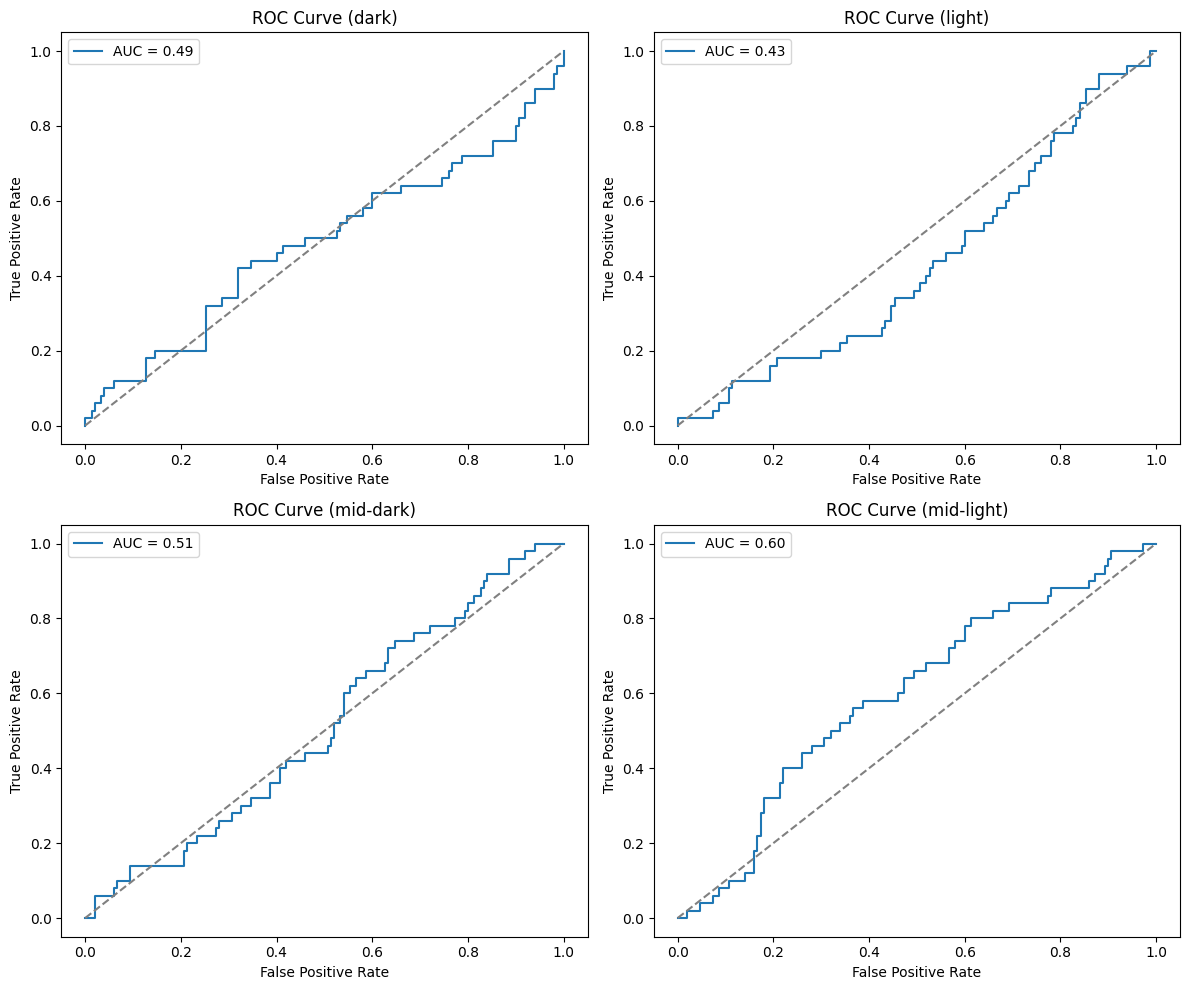

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Number of classes
num_classes = 4
class_labels = ['dark', 'light', 'mid-dark', 'mid-light']  # Adjust according to your labels

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten for easy indexing

# Loop through each class
for i in range(num_classes):
    # Convert y_true to binary for the current class
    y_true_binary = (y_true == i).astype(int)

    # Get predicted probabilities for the current class
    y_score = Y_pred[:, i]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    axes[i].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
    axes[i].set_title(f'ROC Curve ({class_labels[i]})')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].legend()

plt.tight_layout()
plt.show()

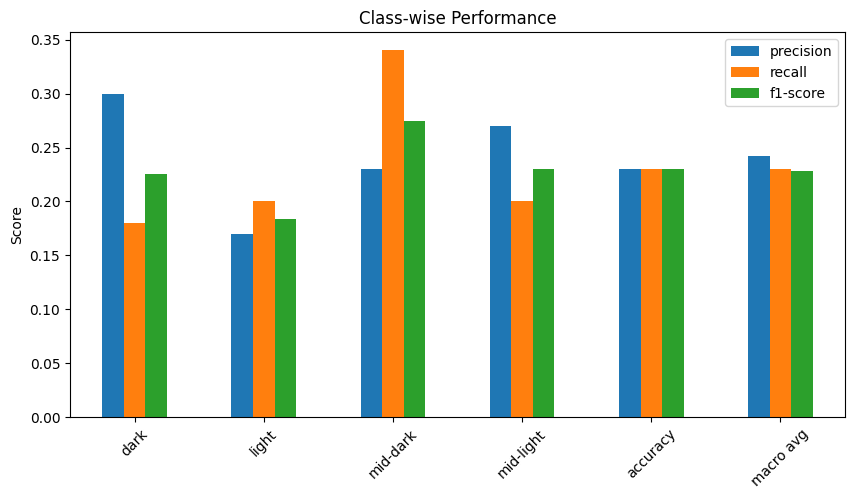

In [33]:
#Class-wise Performance (Bar Chart)

from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, target_names=categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 5))
plt.title('Class-wise Performance')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()